In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [2]:
import torch
import torchtuples as tt

In [3]:
from pycox.datasets import support
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [5]:
np.random.seed(123)
_ = torch.manual_seed(123)

In [6]:
df_train = support.read_df()

Dataset 'support' not locally available. Downloading...
Done


In [9]:
df_test = df_train.sample(frac = 0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac = 0.2)
df_train = df_train.drop(df_val.index)

In [10]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
2,23.399990,1.0,2.0,3.0,0.0,0.0,1.0,87.0,144.0,45.0,37.296879,130.0,5.199219,1.199951,96.0,1
3,53.075989,1.0,4.0,3.0,0.0,0.0,0.0,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927,892.0,0
15,59.468990,1.0,1.0,1.0,0.0,0.0,2.0,109.0,112.0,30.0,36.000000,127.0,20.898438,1.099854,87.0,1
16,39.345982,0.0,2.0,2.0,0.0,0.0,1.0,59.0,60.0,32.0,36.195309,143.0,9.599609,2.500000,8.0,1
18,69.748962,1.0,2.0,1.0,0.0,0.0,1.0,120.0,106.0,40.0,38.093750,135.0,27.699219,10.298828,988.0,0


In [11]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

In [12]:
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

In [13]:
x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)

In [14]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [15]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

In [16]:
num_durations = 20
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)

In [17]:
labtrans.cuts

array([   0.,    3.,    5.,    8.,   11.,   16.,   22.,   31.,   46.,
         66.,   96.,  134.,  193.,  267.,  375.,  535.,  775., 1056.,
       1442., 2028.], dtype=float32)

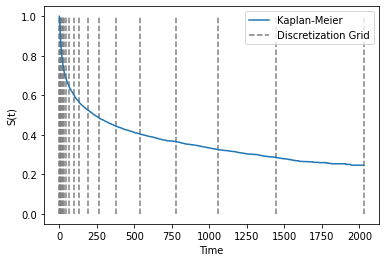

In [18]:
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='gray', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

In [19]:
train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

In [20]:
train.types()

((numpy.ndarray, numpy.ndarray), (numpy.ndarray, numpy.ndarray))

In [21]:
train_tensor = train.to_tensor()

In [22]:
train_tensor.types()

((torch.Tensor, torch.Tensor), (torch.Tensor, torch.Tensor))

In [23]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [24]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [25]:
net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(8, 4)
      (1): Embedding(6, 3)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [26]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/torchtuples/callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  p.data = p.data.add(-weight_decay * eta, p.data)


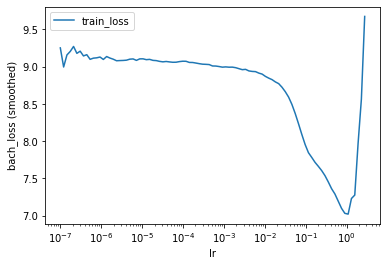

In [27]:
batch_size = 256
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [28]:
model.optimizer.param_groups[0]['lr']

0.10722672220103299

In [29]:
lrfind.get_best_lr()

0.10722672220103299

In [30]:
model.optimizer.set_lr(0.02)

In [31]:
epochs = 512
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = False # set to True if you want printout

In [32]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

CPU times: user 1h 2min 32s, sys: 1min 25s, total: 1h 3min 57s
Wall time: 16min 58s


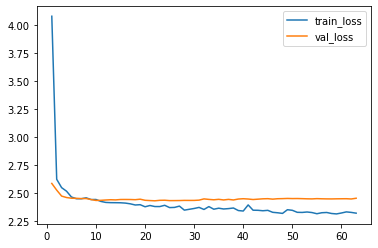

In [33]:
_ = log.to_pandas().iloc[1:].plot()

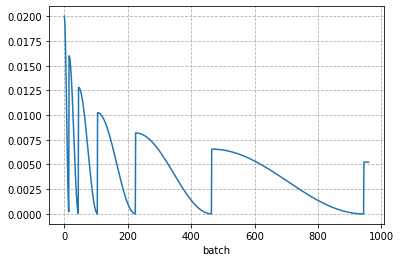

In [34]:
lrs = model.optimizer.lr_scheduler.to_pandas() * model.optimizer.param_groups[0]['initial_lr']
lrs.plot()
plt.grid(linestyle='--')

In [35]:
surv_cdi = model.interpolate(100).predict_surv_df(x_test)
surv_chi = model.interpolate(100, 'const_hazard').predict_surv_df(x_test)

In [36]:
ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')
ev_chi = EvalSurv(surv_chi, durations_test, events_test, censor_surv='km')

In [37]:
ev_cdi.concordance_td(), ev_chi.concordance_td()

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 7000. The TBB threading layer is disabled.
  warnings.warn(problem)


(0.6144321432355122, 0.6145460324186884)

In [38]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev_cdi.integrated_brier_score(time_grid), ev_chi.integrated_brier_score(time_grid)

(0.19477332369763717, 0.2018567618128074)

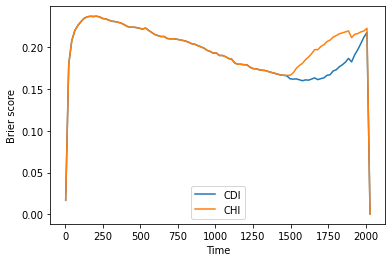

In [39]:
ev_cdi.brier_score(time_grid).rename('CDI').plot()
ev_chi.brier_score(time_grid).rename('CHI').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [40]:
df_train.loc[lambda x: x['duration'] > 1500]['event'].mean()

0.075

In [41]:
test = tt.tuplefy(x_test, (durations_test, events_test))
data = test.iloc[(durations_test > 1500) & (events_test == 0)]
n = data[0][0].shape[0]

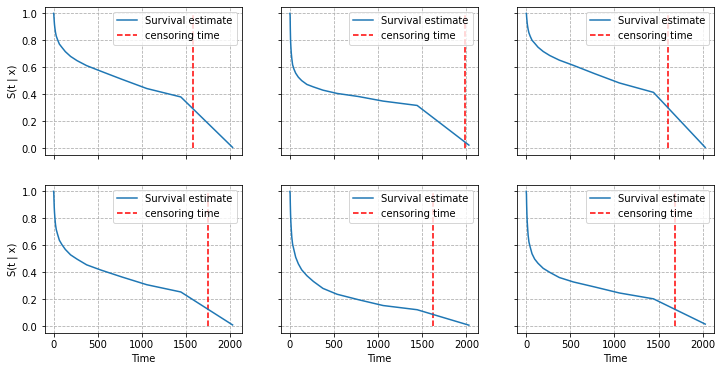

In [42]:
idx = np.random.choice(n, 6)
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
for i, ax in zip(idx, axs.flat):
    x, (t, _) = data.iloc[[i]]
    surv = model.predict_surv_df(x)
    surv[0].rename('Survival estimate').plot(ax=ax)
    ax.vlines(t, 0, 1, colors='red', linestyles="--",
               label='censoring time')
    ax.grid(linestyle='--')
    ax.legend()
    ax.set_ylabel('S(t | x)')
    _ = ax.set_xlabel('Time')